In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# читаем файлы
facts = pd.read_excel('01_Facts.xlsx', header = None)
data = pd.read_csv('02_Data_test.csv', sep = ';')
devices = pd.read_csv('03_устройства.csv', sep = ',')
event_type = pd.read_excel('04_event_type.xlsx')

facts.columns = ['m1', 'm2']

In [3]:
data.isnull().sum()

lac                0
cid                0
msisdn             0
imei           11588
event_type         0
tstamp             0
long               0
lat                0
max_dist           0
cell_type          0
start_angle        0
end_angle          0
dtype: int64

In [4]:
# Создаем новую категорию (BS в группе)
data['lac+cid'] = data['lac'].astype('str', copy = False) + ' ' + data['cid'].astype('str', copy = False)
data.drop('cid', axis='columns', inplace=True)

data['tstamp'] = data['tstamp']/1000
data['tstamp'] = data['tstamp'].astype('int64', copy = False) 

data['event_type'] = data['event_type'].astype('str', copy = False) # меняем тип на категориальный

data['imei'].fillna(0, inplace = True) # импутация пропусков для дальнейших вычислений. 
# В дальнейшем создадим отдельную переменную, поэтому пока не так важно, как именно импутируем
data['imei'] = data['imei'].astype('int64', copy = False)

In [5]:
# подтягиваем информацию об устройствах
data['tac'] = data['imei'].map(lambda x: int(str(x)[:8]))
data= pd.merge(data, devices, how='left', on='tac')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174123 entries, 0 to 174122
Data columns (total 16 columns):
lac            174123 non-null int64
msisdn         174123 non-null int64
imei           174123 non-null int64
event_type     174123 non-null object
tstamp         174123 non-null int64
long           174123 non-null float64
lat            174123 non-null float64
max_dist       174123 non-null int64
cell_type      174123 non-null object
start_angle    174123 non-null float64
end_angle      174123 non-null float64
lac+cid        174123 non-null object
tac            174123 non-null int64
vendor         134011 non-null object
platform       134011 non-null object
type           134011 non-null object
dtypes: float64(4), int64(6), object(6)
memory usage: 22.6+ MB


In [7]:
# В данных переменных довольно много пропусков, создадим отдельную категорию для них
for i in ['vendor', 'platform', 'type']:
    data[i].fillna('OTHER', inplace = True)

In [8]:
# Кодирование категориальных переменных частотой
for i in ['lac', 'lac+cid', 'imei', 'event_type', 'cell_type', 'vendor', 'platform', 'type']:
    freq_encoding = data[i].value_counts() / len(data[i])
    data[i + 'freq'] = data[i].map(freq_encoding)

data.drop(['lac', 'lac+cid', 'event_type', 'cell_type', 'platform', 'type'], axis = 1, inplace = True)

In [9]:
# импутируем пропущнные значения в категориях imei и vendor средней частотой
k = int(data[data['imei'] != 0].groupby(['imei'])['imei'].count().mean())/len(data['imei'])
data.loc[(data['imei'] == 0), 'imeifreq'] = k

k = int(data[data['vendor'] != 'OTHER'].groupby(['vendor'])['vendor'].count().mean())/len(data['vendor'])
data.loc[(data['vendor'] == 'OTHER'), 'vendorfreq'] = k

In [10]:
data.drop(['imei', 'vendor', 'tac'], axis = 1, inplace = True)

In [11]:
# Создаем аггрегированный датасет
Table = data.groupby('msisdn').agg({'tstamp': ['min', 'max', 'mean'], 
                                    'long': ['min', 'max', 'mean'], 
                                    'lat' : ['min', 'max', 'mean'],
                                    'max_dist' : ['min', 'max', 'mean'],
                                    'start_angle' : ['min', 'max', 'mean'],
                                    'end_angle' : ['min', 'max', 'mean'],
                                    'lacfreq' : ['min', 'max'],
                                    'lac+cidfreq' : ['min', 'max'],
                                    'imeifreq' : ['min', 'max'],
                                    'event_typefreq' : 'mean',
                                    'cell_typefreq' : 'mean',
                                    'vendorfreq' : 'max', 
                                    'platformfreq': ['max', 'mean'],
                                    'typefreq': ['max', 'mean']})

In [12]:
T = Table.reset_index(col_level = 1)

In [13]:
T.columns = T.columns.droplevel()

In [14]:
# Для дальнейшего расчета векторного расстояния между объектами нам необходимо привести данные к одному масштабу
from sklearn.preprocessing import StandardScaler

In [15]:
msisdn = T['msisdn']
T.drop('msisdn', axis = 1, inplace = True)

scaler = StandardScaler()
scaler.fit(T)
T_scaler = scaler.transform(T)

In [16]:
F = pd.DataFrame(T_scaler, index = range(T_scaler.shape[0]), columns = range(T_scaler.shape[1]))

In [17]:
# Расчитываем векторное расстояние до каждого объекта с помощью алгоритма KNN
from sklearn.neighbors import NearestNeighbors

In [18]:
nbrs = NearestNeighbors(n_neighbors=2361, algorithm='auto').fit(F)

In [19]:
dist, ind = nbrs.kneighbors(F)

In [20]:
dist # Расстояние

array([[ 0.        ,  3.31556613,  5.65467319, ..., 24.70130994,
        30.46333223, 43.95834274],
       [ 0.        ,  2.50259563,  2.52905437, ..., 22.20253721,
        28.20229769, 42.86226913],
       [ 0.        ,  3.10710569,  3.48388059, ..., 22.10769699,
        27.81236531, 42.85843232],
       ...,
       [ 0.        ,  2.08399996,  2.11834897, ..., 21.96702121,
        28.02991442, 42.96971663],
       [ 0.        ,  5.51587742,  7.36692348, ..., 25.21983288,
        25.49259701, 42.96716912],
       [ 0.        ,  2.0533891 ,  2.62953738, ..., 21.86898186,
        27.76927126, 42.6920319 ]])

In [21]:
ind # Индексы

array([[   0, 1030,  758, ...,  229, 1896,  832],
       [   1,  823,  478, ...,  298, 1896,  832],
       [   2, 1477, 1975, ...,  298, 1896,  832],
       ...,
       [2358, 1597, 1989, ...,  229, 1896,  832],
       [2359,   80, 2051, ..., 1372,  229,  832],
       [2360,  140, 1808, ...,  298, 1896,  832]], dtype=int64)

In [22]:
#Список индексов телефонов, которые принаждежат одному абоненту - пара значений
index_number = []
for i in range(121):
    a = facts['m1'][i]
    b = facts['m2'][i] 
    c = list(msisdn.loc[(msisdn == a) | (msisdn == b)].index)
    index_number.append(c)

In [23]:
# для упрощения расчетов уберем из выборки тех, у кого меньше 2 номеров
for i in index_number:
    if len(i) < 2:
        index_number.remove(i)

In [24]:
# расстояния между абонентами, предположительно являющимися одним и тем же лицом
dist_twice_abonents = []
for i in index_number:
    for j in list(ind[i[0]]):
        if j == i[1]:
            d = dist[i[0]][list(ind[i[0]]).index(i[1])]
            dist_twice_abonents.append(d)

In [25]:
import statistics as s
from scipy.stats import norm
import seaborn as sns

In [26]:
# функция для формирования массивов расстояний в случайных группах абонентов
def gen_list_rand_abonents(ind, dist, i, j, z):
    rand_abonents = []
    for i in range(1, i, j):
        k = list(ind[z]).index(i)
        rand_abonents.append(dist[z][k]) 
    return rand_abonents

In [27]:
# Делаем массив с несколькими случайными выборками
list_rand_abonents = []
for i in [100,110,120,130,140,150,160,170,180,190]:
    r_a = gen_list_rand_abonents(ind, dist, 1000, 10, i)
    list_rand_abonents.append(r_a)

In [28]:
print('среднее расстояние между SIM, принадлежащих одному лицу:')
print(round(s.mean(dist_twice_abonents), 3))

среднее расстояние между SIM, принадлежащих одному лицу:
5.821


In [29]:
print('Средние расстояния для случайных групп абонентов:')
for i in list_rand_abonents:
    print(round(s.mean(i),3))

Средние расстояния для случайных групп абонентов:
7.452
11.014
8.796
9.547
6.298
6.242
6.616
6.3
10.546
6.055


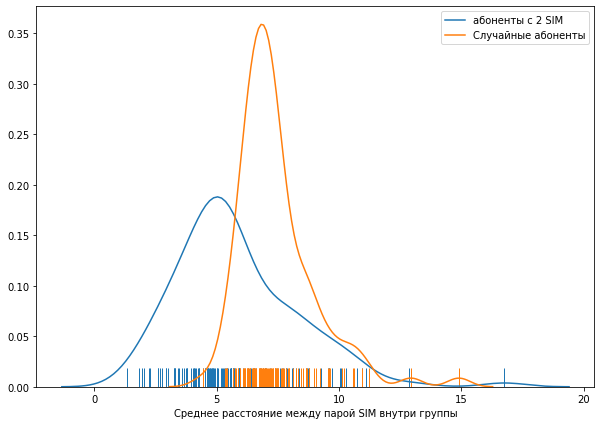

In [30]:
# построим распределение получившихся расстояний
fig, ax = plt.subplots(figsize=(10, 7))
sns.distplot(dist_twice_abonents, rug=True, hist=False, axlabel='Среднее расстояние между парой SIM внутри группы', label='абоненты с 2 SIM')
sns.distplot(list_rand_abonents[0], rug=True, hist=False, label = 'Случайные абоненты');

In [31]:
# Cформируем список абонентов
index_a = []
for i in range(2361):
    index_a.append(ind[i][1])

In [32]:
index_a = pd.DataFrame(data = {'ind': index_a})

In [33]:
result = pd.concat([index_a, msisdn], axis=1)

In [34]:
result['msisdn_2'] = 0
for i in result['ind']:
    ms = int(result.loc[i, 'msisdn'])
    result.loc[result['ind'] == i, 'msisdn_2'] = ms
    
result.drop('ind', axis = 1, inplace = True)

In [37]:
result.to_excel('result.xlsx')